# <p align=center> Analysez les ventes d'une librairie avec Python <p>

Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# SOMMAIRE<br> <a class="anchor" id="sommaire"></a>

- __[1. Préparation des Données](#1-préparation-des-données)__<br>
   - [1.1. Table Customers](#11-table-customers)<br>
   - [1.2. Table Products](#12-table-products)<br>
   - [1.3. Table Transactions](#13-table-transaction)<br>
   - [1.4. Fusion et Nettoyage](#14-fusion-des-tables-et-nettoyage)<br>
- __[2. Analyse du chiffre d'affaire](#2-analyse-du-chiffre-daffaire)__<br>
   - [2.1. Première Analyse](#21-première-analyse)<br>
   - [2.2. Analyse et Correction de l'Anomalie](#22-analyse-et-correction-de-lanomalie)<br>
   - [2.3. Analyses autour du Chiffre d'Affaire](#23-analyses-autour-du-chiffre-daffaire)<br>
   - [2.4. Analyse de la saisonalité](#24-analyse-de-la-saisonalité)<br>
- __[3. Analyse de la clientèle](#3-analyse-de-la-clientèle)__<br>
   - [3.1. RFM](#31-rfm)<br>
   - [3.2. Panier Total par Cleint](#32-panier-total-par-client)<br>
   - [3.3. Panier moyen](#33panier-moyer-par-client)<br>
   - [3.4. Fréquences d'achat](#33panier-moyer-par-client)<br>
- __[4. Analyses statistiques](#4-analyses-statistiques)__<br>
   - [4.1 Analyses de deux variables qualitatives](#41-analyses-de-deux-variables-qualitatives)<br>
   - [4.2 Analyses de deux variables quantitatives](#42-analyses-de-deux-variables-quantitatives)<br>
   - [4.3 Analyses d'une variable qualitative et d'une variable quantitative](#43-analyses-dune-variable-qualitative-et-dune-variable-quantitative)<br>

## 1. Préparation des données <a class="anchor" id="1-préparation-des-données">

**Import des librairies**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

sns.set(style="darkgrid")


import warnings
warnings.simplefilter("ignore")

**Import des tables**

In [2]:
customers = pd.read_csv('customers.csv')

products = pd.read_csv('products.csv')

transactions = pd.read_csv('transactions.csv')

**Définitons des fonctions et constantes**

In [3]:
def Nettoyage (df): #Visualisation préliminaires des données
    print(df.head(2))
    print("-----------------------------------")
    print("Shape")
    print(df.shape)
    print("-----------------------------------")
    print("Types")
    print(df.dtypes)
    print("-----------------------------------")
    print("Valeurs Nulles")
    print(df.isnull().sum())
    return

def Doublons(df,pk): #Analyse des doublons
    print(df.loc[df[pk].duplicated(keep=False),:])
    return

def Liste_na(df,pk,na):
    df_na = df[df.isna().any(axis=1)]
    list_na = df_na[[pk,na]]
    list_na = list_na[list_na[na].isnull()]
    print(list_na[pk].dropna().value_counts())
    print(f"{len(list_na[pk].dropna().value_counts())} références n'ont pas de valeur associée.")
    return

def Compte_Zscore(x,y,z,var):
    compte_zscore = x[x[y]==var]
    compte_zscore['zscore']=st.zscore(compte_zscore[z])
    print(len(compte_zscore[(compte_zscore['zscore']>=3)|(compte_zscore['zscore']<=-3)]))
    return

def Courbe_Lorenz(x,y):
    depenses = x[x[y] > 0]
    dep = depenses[y].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.title('Courbe de Lorenz')
    plt.show()
    return

def reponse_test (p):
    alpha = 0.05 # niveau de signification
    print(f"P-value =  {p}")
    if p > alpha:
        print("Acceptation de H0")
    else:
        print("Rejet de H0")
    return




### 1.1. Table Customers <a class="anchor" id="11-table-customers">

In [4]:
Nettoyage(customers)

  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
-----------------------------------
Shape
(8623, 3)
-----------------------------------
Types
client_id    object
sex          object
birth         int64
dtype: object
-----------------------------------
Valeurs Nulles
client_id    0
sex          0
birth        0
dtype: int64


In [5]:
Doublons(customers,'client_id')

Empty DataFrame
Columns: [client_id, sex, birth]
Index: []


**Analyse de la table *Customers***

In [6]:
#Calcul de l'age 
customers['age'] = dt.datetime.today().year - customers['birth']
customers.head()

,client_id,sex,birth,age
0,c_4410,f,1967,56
1,c_7839,f,1975,48
2,c_1699,f,1984,39
3,c_5961,f,1962,61
4,c_5320,m,1943,80


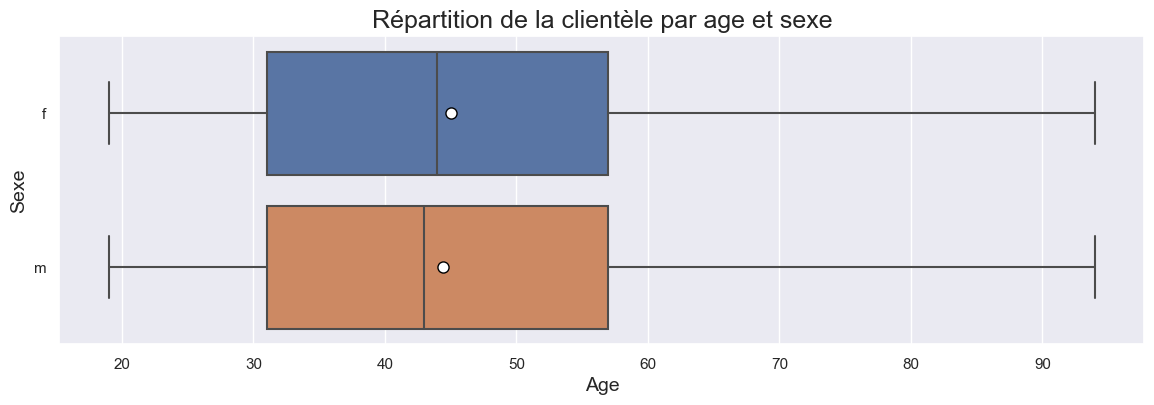

In [7]:
sns.set(rc={"figure.figsize":(14, 4)})
sns.boxplot(customers,x='age',y='sex',showmeans=True,meanprops={"marker": "o","markerfacecolor":"white","markeredgecolor": "black","markersize": "8"})
plt.ylabel("Sexe", size=14)
plt.xlabel("Age", size=14)
plt.title("Répartition de la clientèle par age et sexe", size=18)
plt.show()

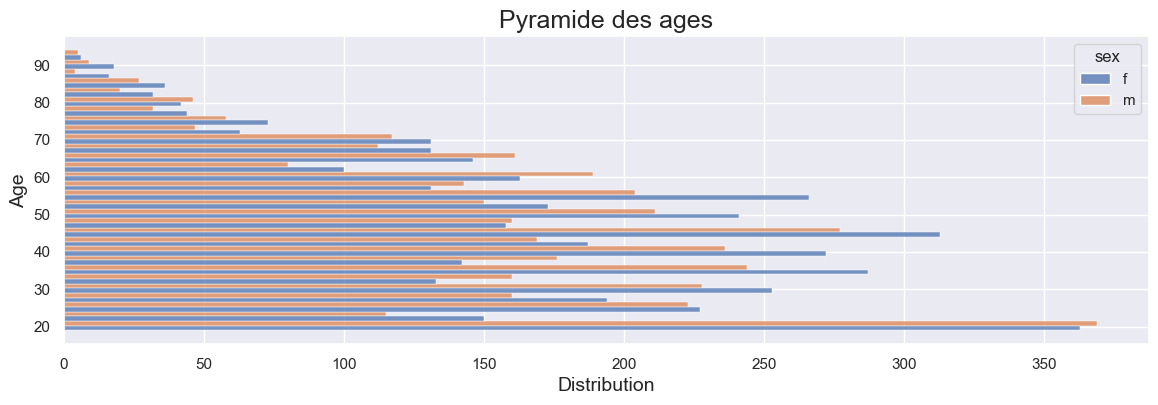

In [8]:
sns.histplot(customers,y="age",hue='sex',multiple="dodge")
sns.set(rc={"figure.figsize":(10, 8)})
plt.ylabel("Age", size=14)
plt.xlabel("Distribution", size=14)
plt.title("Pyramide des ages", size=18)
plt.show()

### 1.2. Table Products

In [9]:
Nettoyage(products)

  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
-----------------------------------
Shape
(3287, 3)
-----------------------------------
Types
id_prod     object
price      float64
categ        int64
dtype: object
-----------------------------------
Valeurs Nulles
id_prod    0
price      0
categ      0
dtype: int64


In [10]:
Doublons(products,'id_prod')

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []


In [11]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


Verification de la valeur Price = -1

In [12]:
print(products[products['price'] ==-1])

    id_prod  price  categ
731     T_0   -1.0      0


**Analyse de la table *Product***

In [13]:
products.pivot_table(index='categ', values = 'price' , aggfunc='count', margins = True, margins_name='Total')

,price
categ,
0,2309
1,739
2,239
Total,3287


Text(0.5, 1.0, 'Représentation de la distribution des prix en fonction des catégories')

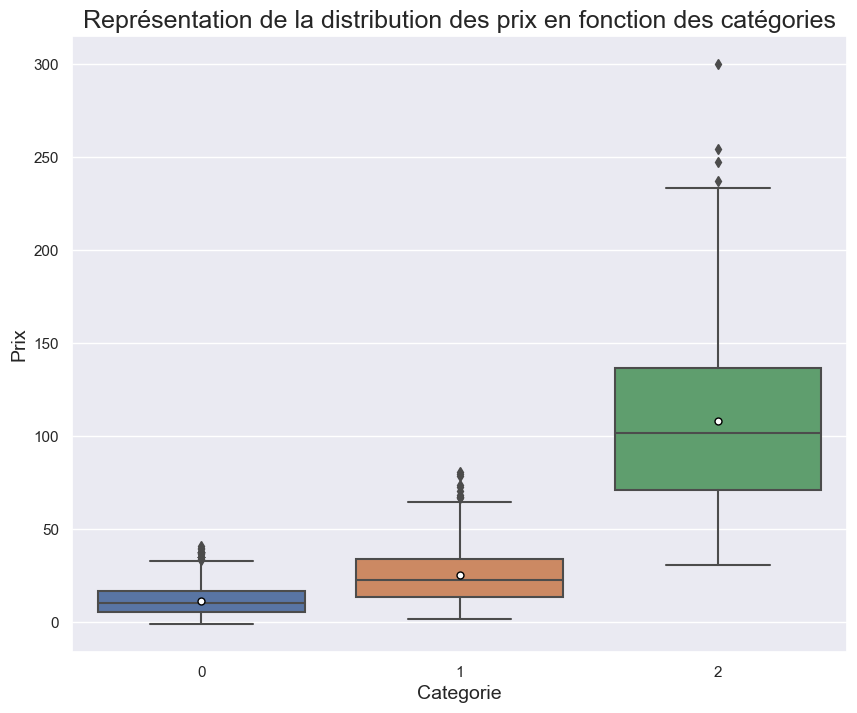

In [14]:
sns.boxplot(products,x='categ',y='price',showmeans = True,meanprops={"marker": "o","markerfacecolor":"white","markeredgecolor": "black","markersize": "5"})
sns.set(rc={"figure.figsize":(10, 6)})
plt.ylabel("Prix", size=14)
plt.xlabel("Categorie", size=14)
plt.title("Représentation de la distribution des prix en fonction des catégories", size=18)

Dénombrement des outliers - Z-SCORE

Categ = 0

In [15]:
Compte_Zscore(products,'categ','price',0)

20


Categ = 1

In [16]:
Compte_Zscore(products,'categ','price',1)

5


Categ = 2

In [17]:
Compte_Zscore(products,'categ','price',2)

1


### 1.3. Table Transaction

In [18]:
Nettoyage(transactions)

  id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
-----------------------------------
Shape
(679532, 4)
-----------------------------------
Types
id_prod       object
date          object
session_id    object
client_id     object
dtype: object
-----------------------------------
Valeurs Nulles
id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


In [19]:
transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


Analyse session_id s_0

In [20]:
test = transactions[transactions['session_id']=='s_0']
print(test)

for col in test:
    print(test[col].unique())

       id_prod                             date session_id client_id
3019       T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
5138       T_0  test_2021-03-01 02:30:02.237425        s_0      ct_0
9668       T_0  test_2021-03-01 02:30:02.237437        s_0      ct_1
10728      T_0  test_2021-03-01 02:30:02.237436        s_0      ct_0
15292      T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0
...        ...                              ...        ...       ...
657830     T_0  test_2021-03-01 02:30:02.237417        s_0      ct_0
662081     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1
670680     T_0  test_2021-03-01 02:30:02.237449        s_0      ct_1
671647     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1
679180     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1

[200 rows x 4 columns]
['T_0']
['test_2021-03-01 02:30:02.237419' 'test_2021-03-01 02:30:02.237425'
 'test_2021-03-01 02:30:02.237437' 'test_2021-03-01 02:30:02.237436'
 '

Nous avons donc 200 tests ayant comme *session_id* s_0, *client_id* ct_0 et ct_1 et *id_prod* T_0

In [21]:
transactions.drop(transactions[transactions['session_id']=='s_0'].index, inplace=True)
customers.drop(customers[(customers['client_id']=='ct_0')&(customers['client_id']=='ct_1')].index, inplace=True)
products.drop(products[products['id_prod']=='T_0'].index, inplace=True)
transactions['date'] = pd.to_datetime(transactions['date'],format="%Y-%m-%d")


### 1.4. Fusion des tables et Nettoyage <a class="anchor" id="14-fusion-des-tables-et-nettoyage">

In [22]:
transactions_products = pd.merge(transactions ,products, on = 'id_prod', how = 'outer')
data = pd.merge(transactions_products ,customers, on = 'client_id', how ='outer')

In [23]:
Nettoyage(transactions_products)


  id_prod                       date session_id client_id  price  categ
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0
1  0_1518 2021-09-26 12:37:29.780414    s_95811    c_6197   4.18    0.0
-----------------------------------
Shape
(679353, 6)
-----------------------------------
Types
id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
price                float64
categ                float64
dtype: object
-----------------------------------
Valeurs Nulles
id_prod         0
date           21
session_id     21
client_id      21
price         221
categ         221
dtype: int64


In [24]:
Nettoyage(data)

  id_prod                       date session_id client_id  price  categ sex  \
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1  0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   f   

    birth   age  
0  1986.0  37.0  
1  1986.0  37.0  
-----------------------------------
Shape
(679376, 9)
-----------------------------------
Types
id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
price                float64
categ                float64
sex                   object
birth                float64
age                  float64
dtype: object
-----------------------------------
Valeurs Nulles
id_prod        23
date           44
session_id     44
client_id      21
price         244
categ         244
sex            21
birth          21
age            21
dtype: int64


21 Articles ne se sont pas vendus du tout. 23 Clients n'ont rien commandé. 221 sessions n'ont pas de prix.

In [25]:
Liste_na(data,'client_id','id_prod')

c_8253    1
c_1223    1
ct_1      1
c_587     1
c_90      1
c_7584    1
c_862     1
c_6735    1
c_5223    1
c_5245    1
c_6862    1
c_8381    1
c_3789    1
c_4358    1
c_6930    1
c_4086    1
c_3017    1
c_4447    1
c_3443    1
c_2706    1
ct_0      1
c_4406    1
c_3526    1
Name: client_id, dtype: int64
23 références n'ont pas de valeur associée.


In [26]:
Liste_na(data,"id_prod","session_id")

0_1016    1
0_1025    1
0_510     1
0_299     1
2_86      1
0_1624    1
0_310     1
2_72      1
1_394     1
2_87      1
0_1620    1
0_1780    1
0_322     1
0_1645    1
0_1800    1
0_1318    1
1_0       1
0_1014    1
0_1119    1
0_1062    1
0_2308    1
Name: id_prod, dtype: int64
21 références n'ont pas de valeur associée.


In [27]:
Liste_na(data,"id_prod","price")

0_2245    221
Name: id_prod, dtype: int64
1 références n'ont pas de valeur associée.


Le produit 0_2245 n'est pas référencé dans la table *products*. Etant vendu 221 fois, on ne peut le supprimer.
Nous l'ajoutons a la table *products* en catego 0 et avec un prix ayant pour valeur la moyenne de la série.

In [28]:
print(products[products['categ']==0]['price'].mean())

11.732794627383015


In [29]:
products = products.append({'id_prod':'0_2245','price':products[products['categ']==0]['price'].mean(),'categ':0},ignore_index=True)

In [30]:
transactions_products = pd.merge(transactions ,products, on = 'id_prod', how = 'outer')
data = pd.merge(transactions_products ,customers, on = 'client_id', how ='outer')
data = data[data['date'].notnull()]
Nettoyage(data)


  id_prod                       date session_id client_id  price  categ sex  \
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1  0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   f   

    birth   age  
0  1986.0  37.0  
1  1986.0  37.0  
-----------------------------------
Shape
(679332, 9)
-----------------------------------
Types
id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
price                float64
categ                float64
sex                   object
birth                float64
age                  float64
dtype: object
-----------------------------------
Valeurs Nulles
id_prod       0
date          0
session_id    0
client_id     0
price         0
categ         0
sex           0
birth         0
age           0
dtype: int64


## 2. Analyse du Chiffre d'Affaire

### 2.1. Première Analyse

**Calcul du CA global**

In [31]:
print(f"Le chiffre d'affaire entre le {data['date'].min()} et le {data['date'].max()} est de {round(data['price'].sum(),2)}€.")

Le chiffre d'affaire entre le 2021-03-01 00:01:07.843138 et le 2023-02-28 23:58:30.792755 est de 11856321.63€.


**CA Journalier**

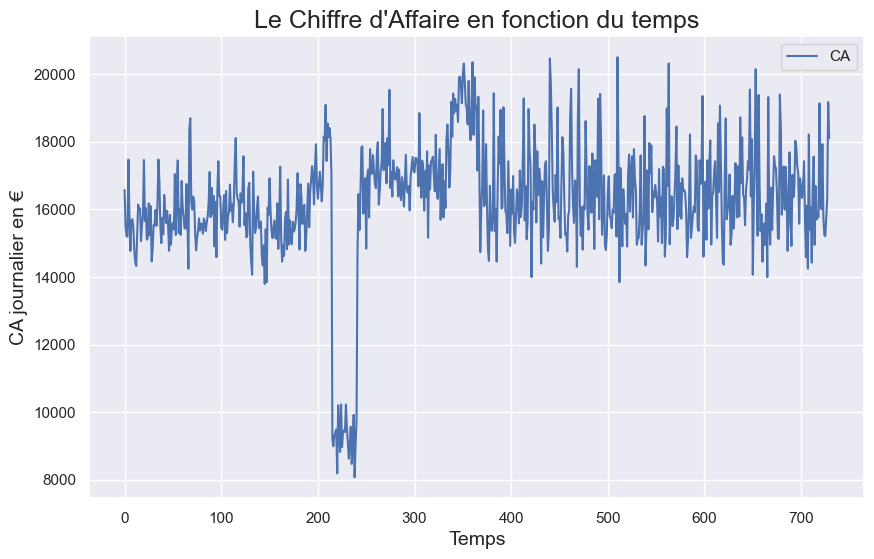

In [32]:
ca_journalier = data.groupby(by=[pd.Grouper(key='date', freq='D')]).agg(CA=('price' , np.sum)).reset_index()
sns.lineplot(ca_journalier)
sns.set(rc={"figure.figsize":(20, 6)})
plt.ylabel("CA journalier en €", size=14)
plt.xlabel("Temps", size=14)
plt.title("Le Chiffre d'Affaire en fonction du temps", size=18)
plt.show()

Problème au mois d'octobre 2021

### 2.2. Analyse et Correction de l'anomalie <a class="anchor" id="22-analyse-et-correction-de-lanomalie"></a>

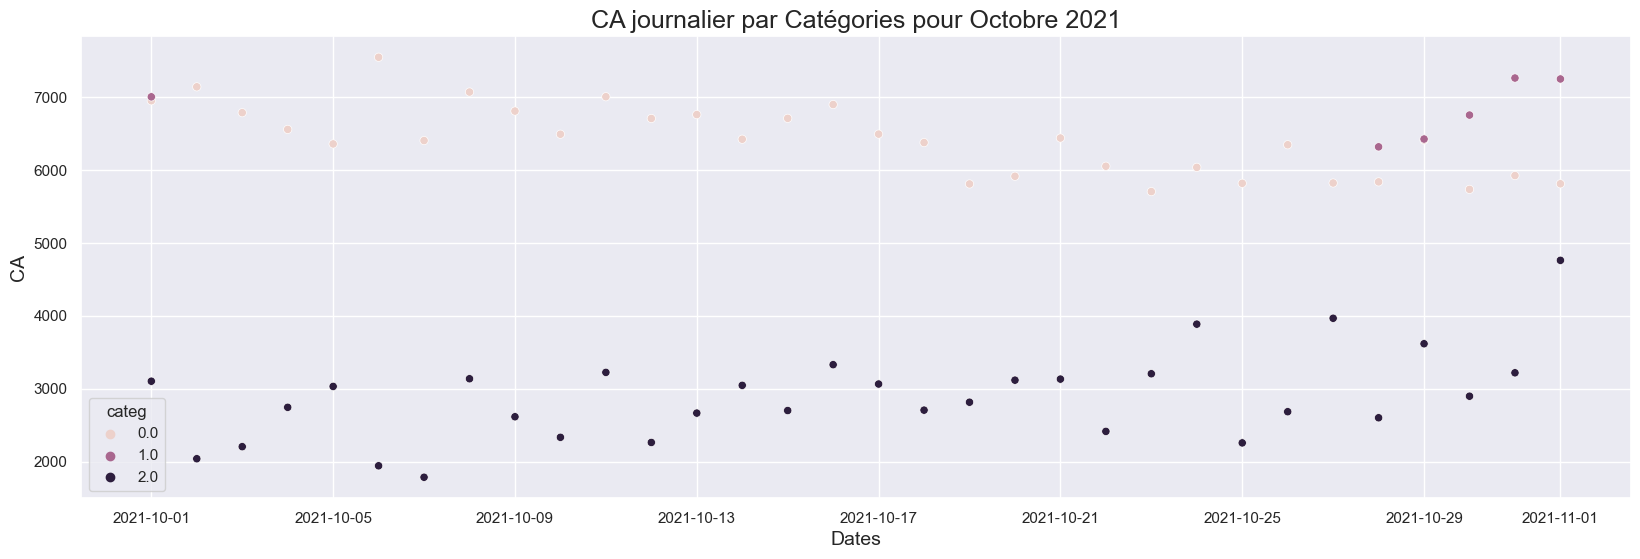

In [33]:
ca_journalier = data.groupby(by=[pd.Grouper(key='date', freq='D'),pd.Grouper(key='categ')]).agg(CA=('price' , np.sum)).reset_index()
ca_mensuel = data.groupby(by=[pd.Grouper(key='date', freq='M'),pd.Grouper(key='categ')]).agg(CA=('price' , np.sum)).reset_index()
ca_octobre = ca_journalier[(ca_journalier['date']>='2021-10')&(ca_journalier['date']<='2021-11')]
sns.scatterplot(ca_octobre,x='date',y='CA',hue='categ')
plt.ylabel("CA", size=14)
plt.xlabel("Dates", size=14)
plt.title("CA journalier par Catégories pour Octobre 2021", size=18)
plt.show()

Pas de Catégorie 1 entre le 02/10/2021 et le 27/10/2021

In [34]:
ca_septmembre = ca_journalier[(ca_journalier['date']>='2021-09')&(ca_journalier['date']<='2021-10')&(ca_journalier['categ']==1)]
ca_novembre = ca_journalier[(ca_journalier['date']>='2021-11')&(ca_journalier['date']<='2021-12')&(ca_journalier['categ']==1)]
mean_nov = ca_novembre['CA'].mean()
mean_sept = ca_septmembre['CA'].mean()
print((mean_nov+mean_sept)/2)

7396.154032258064


Afin de corriger l'anomalie, nous choisissons d'affecter la moyenne du CA de septembre et de novembre de la catégorie 1 aux jours manquants.

In [35]:
start_date = dt.date(2021,10,2)
end_date = dt.date(2021,10,27)
daterange = pd.date_range(start_date, end_date)
for single_date in daterange:
    ca_journalier = ca_journalier.append({'date':single_date,'categ':1,'CA':((mean_nov+mean_sept)/2)},ignore_index=True)

print(ca_journalier[(ca_journalier['date']>='2021-10')&(ca_journalier['date']<='2021-11')])

           date  categ           CA
642  2021-10-01    0.0  6950.500000
643  2021-10-01    1.0  7003.790000
644  2021-10-01    2.0  3104.050000
645  2021-10-02    0.0  7141.010000
646  2021-10-02    2.0  2041.120000
...         ...    ...          ...
2185 2021-10-23    1.0  7396.154032
2186 2021-10-24    1.0  7396.154032
2187 2021-10-25    1.0  7396.154032
2188 2021-10-26    1.0  7396.154032
2189 2021-10-27    1.0  7396.154032

[96 rows x 3 columns]


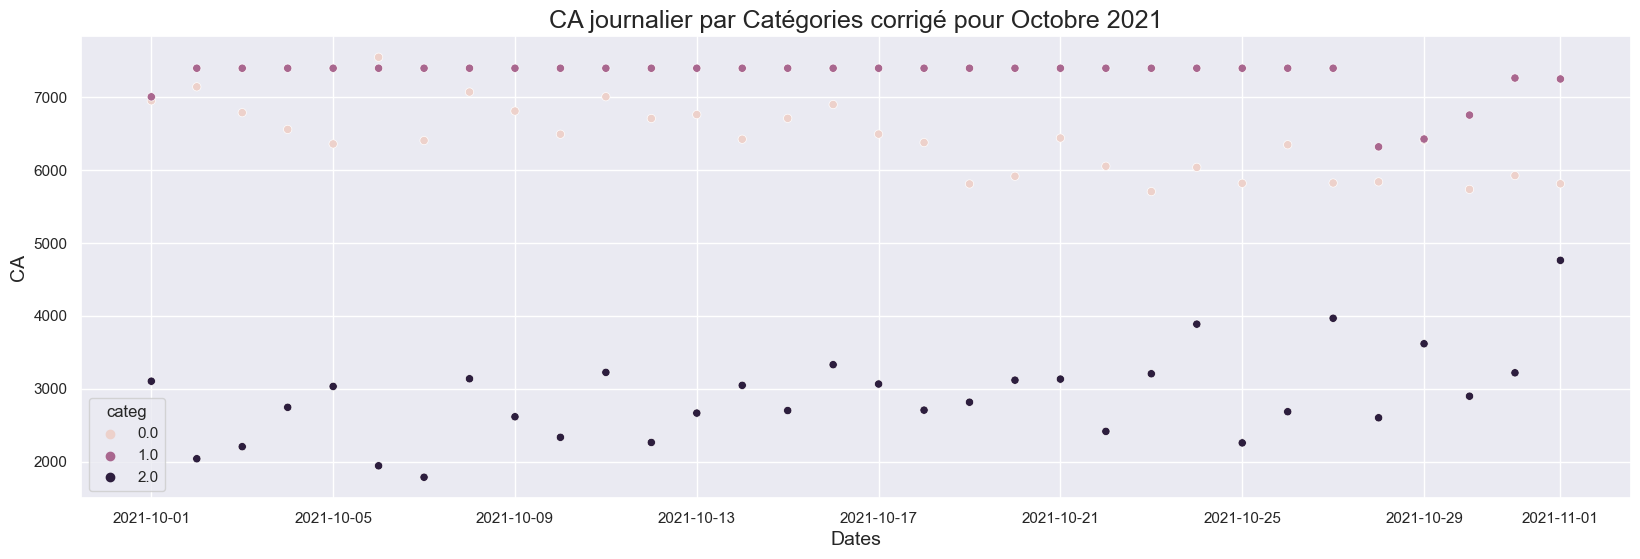

In [36]:
ca_octobre = ca_journalier[(ca_journalier['date']>='2021-10')&(ca_journalier['date']<='2021-11')]
sns.scatterplot(ca_octobre,x='date',y='CA',hue='categ')
plt.ylabel("CA", size=14)
plt.xlabel("Dates", size=14)
plt.title("CA journalier par Catégories corrigé pour Octobre 2021", size=18)
plt.show()

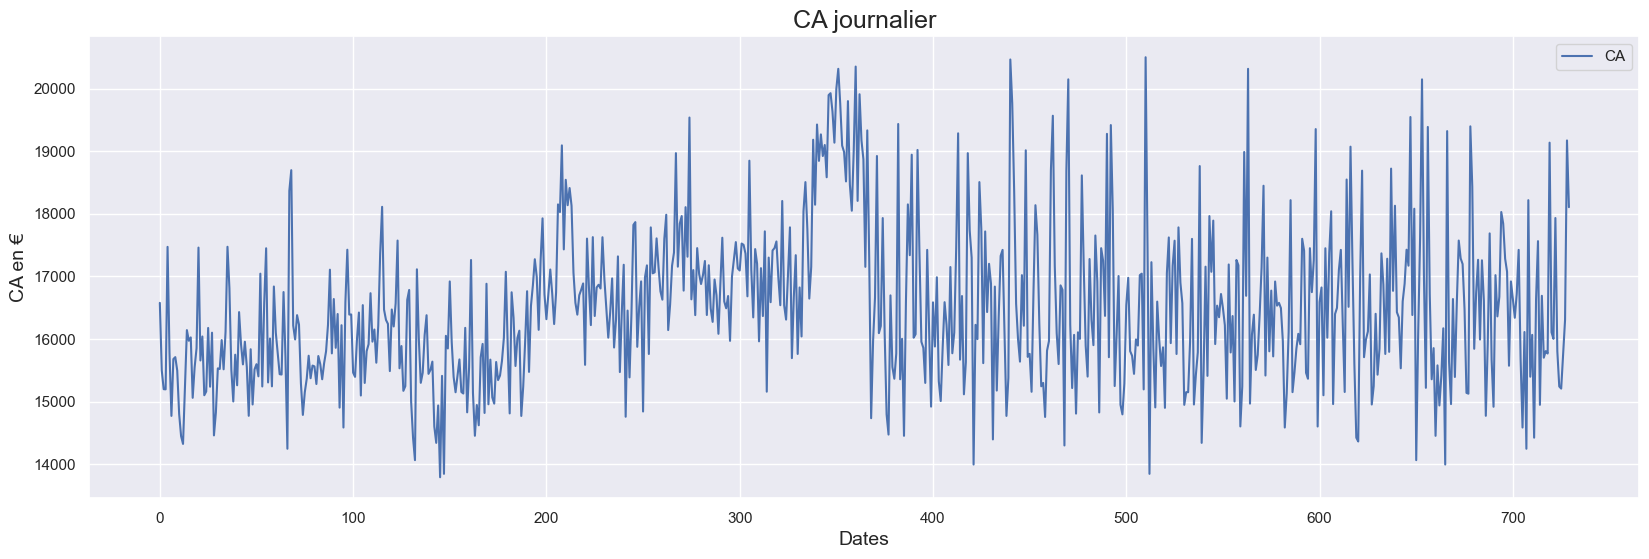

In [37]:
ca_journalier = ca_journalier.groupby(by=[pd.Grouper(key='date', freq='D')]).agg(CA=('CA' , np.sum)).reset_index()
sns.lineplot(ca_journalier)
sns.set(rc={"figure.figsize":(20, 6)})
plt.ylabel("CA en €", size=14)
plt.xlabel("Dates", size=14)
plt.title("CA journalier", size=18)
plt.show()

L'anomalie est corrigée

### 2.3. Analyses autour du Chiffre d'Affaire

CA Global

In [38]:
print(f"Le chiffre d'affaire est de {round(data['price'].sum(),2)}€.")

Le chiffre d'affaire est de 11856321.63€.


CA journalier

In [39]:
print(f"Le chiffre d'affaire journalier moyen est de {round(ca_journalier['CA'].mean(),2)}€.")
print(f"Le chiffre d'affaire journalier median est de {round(ca_journalier['CA'].median(),2)}€.")
print(f"Le chiffre d'affaire journalier max est de {round(ca_journalier['CA'].max(),2)}€.")
print(f"Le chiffre d'affaire journalier max est de {round(ca_journalier['CA'].min(),2)}€.")

Le chiffre d'affaire journalier moyen est de 16504.96€.
Le chiffre d'affaire journalier median est de 16366.52€.
Le chiffre d'affaire journalier max est de 20499.41€.
Le chiffre d'affaire journalier max est de 13792.21€.


**CA par Catégorie par Sex**

In [40]:
data.pivot_table(index='categ',columns='sex', values = 'price' , aggfunc='sum', margins = True, margins_name='Total')

sex,f,m,Total
categ,,,
0.0,2.191386e+06,2.230938e+06,4.422324e+06
1.0,2.358417e+06,2.295306e+06,4.653723e+06
2.0,1.311253e+06,1.469022e+06,2.780275e+06
Total,5.861056e+06,5.995266e+06,1.185632e+07


### 2.4. Analyse de la saisonalité

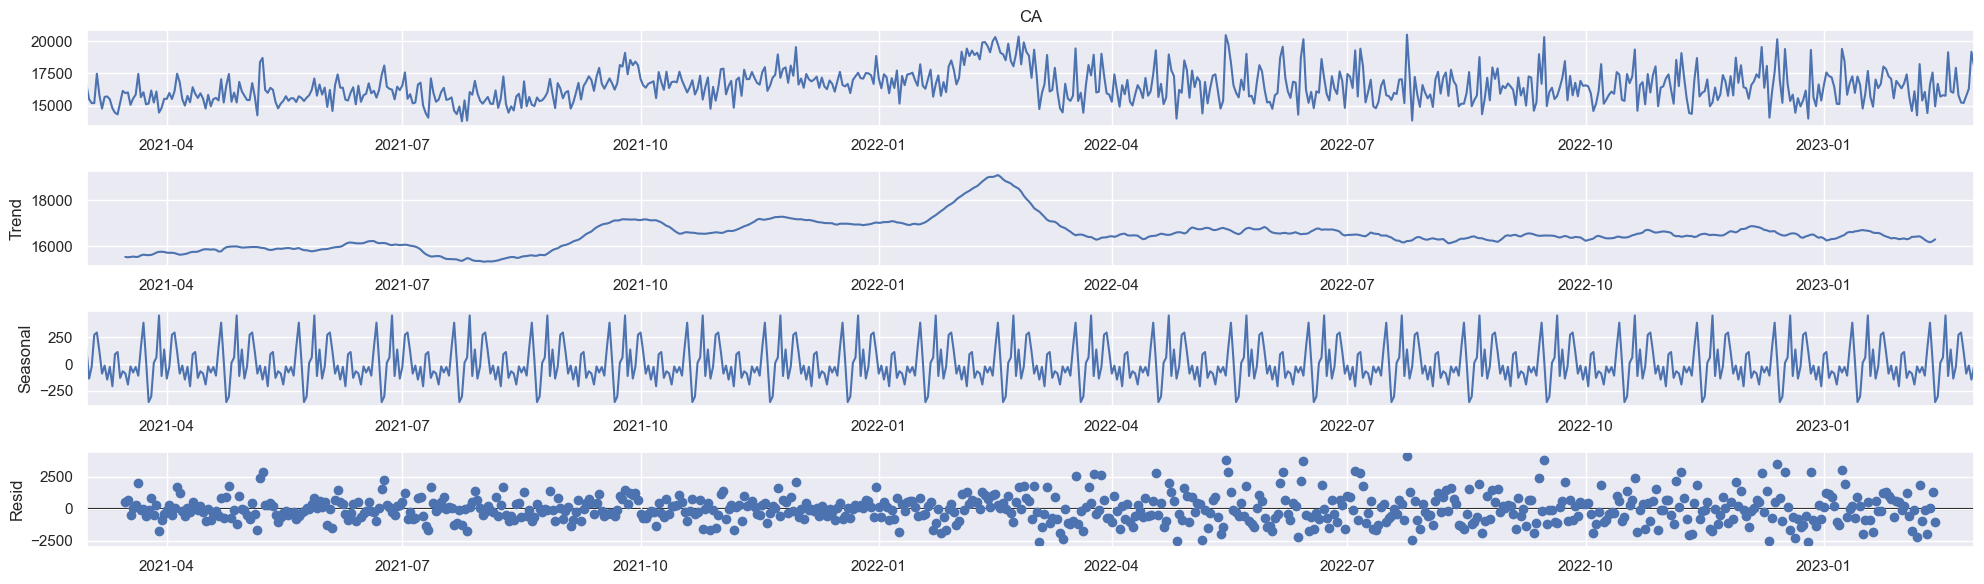

In [41]:
ca_journalier_decomp = ca_journalier.set_index('date')
ca_journalier_decomp = ca_journalier_decomp['CA'].astype(str)
decomp_x = seasonal_decompose(ca_journalier_decomp, period = 30)
decomp_x.plot()
plt.show()


Décomposition des moyennes mobiles

In [42]:
ca_journalier['moyenne_mobile_30']= ca_journalier['CA'].rolling(30,min_periods=1).mean()

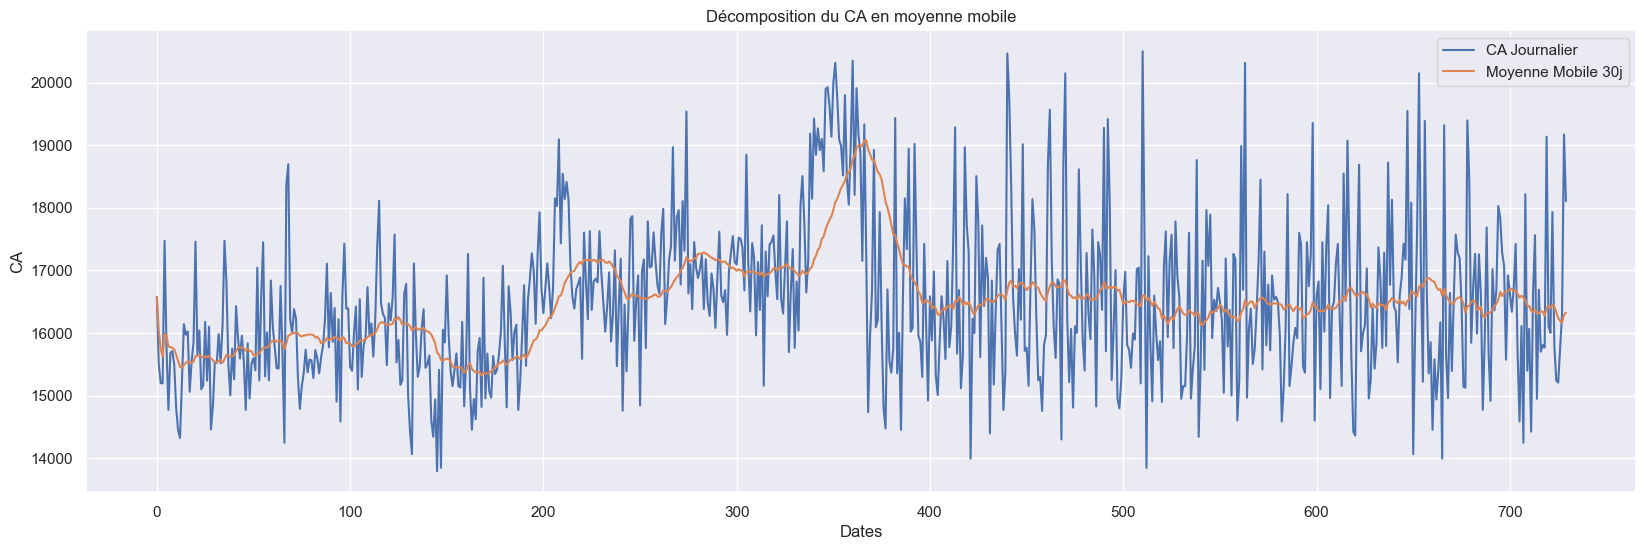

In [43]:
plt.plot(ca_journalier['CA'], label='CA Journalier')
plt.plot(ca_journalier['moyenne_mobile_30'], label='Moyenne Mobile 30j')
plt.legend()
plt.ylabel('CA')
plt.xlabel('Dates')
plt.title('Décomposition du CA en moyenne mobile')
plt.show()

Top25 par CA

In [44]:
topflop = data.groupby(by=[pd.Grouper(key='id_prod')]).agg(CA=('price' , np.sum),nb=('session_id' , len)).reset_index()
topflop.sort_values('CA',ascending=False).head(25)

,id_prod,CA,nb
3097,2_159,94893.50,650
3071,2_135,69334.95,1005
3046,2_112,65407.76,968
3035,2_102,60736.78,1027
3153,2_209,56971.86,814
2620,1_395,54356.25,1875
2592,1_369,54025.48,2252
3044,2_110,53846.25,865
3202,2_39,53060.85,915
3105,2_166,52449.12,228


Flop25 par CA (hors les 21 références non vendues)

In [45]:
topflop.sort_values('CA',ascending=True).head(25)

,id_prod,CA,nb
595,0_1539,0.99,1
313,0_1284,1.38,1
719,0_1653,1.98,2
1785,0_541,1.99,1
2080,0_807,1.99,1
665,0_1601,1.99,1
802,0_1728,2.27,1
549,0_1498,2.48,1
2180,0_898,2.54,2
925,0_1840,2.56,2


Top 25 par nombre de ventes

In [46]:
topflop.sort_values('nb',ascending=False).head(25)

,id_prod,CA,nb
2592,1_369,54025.48,2252
2645,1_417,45947.11,2189
2642,1_414,51949.40,2180
2734,1_498,49731.36,2128
2654,1_425,35611.04,2096
2630,1_403,35260.40,1960
2640,1_412,32484.15,1951
2641,1_413,34990.55,1945
2633,1_406,48106.59,1939
2634,1_407,30940.65,1935


Flop25 par nb de vente (hors les 21 références non vendues)

In [47]:
topflop.sort_values('nb',ascending=True).head(25)

,id_prod,CA,nb
1793,0_549,2.99,1
1327,0_2201,20.99,1
3176,2_23,115.99,1
313,0_1284,1.38,1
752,0_1683,2.99,1
2109,0_833,2.99,1
3264,2_98,149.74,1
698,0_1633,24.99,1
665,0_1601,1.99,1
3248,2_81,86.99,1


Prévision du CA - méthode de Holt-Winters :

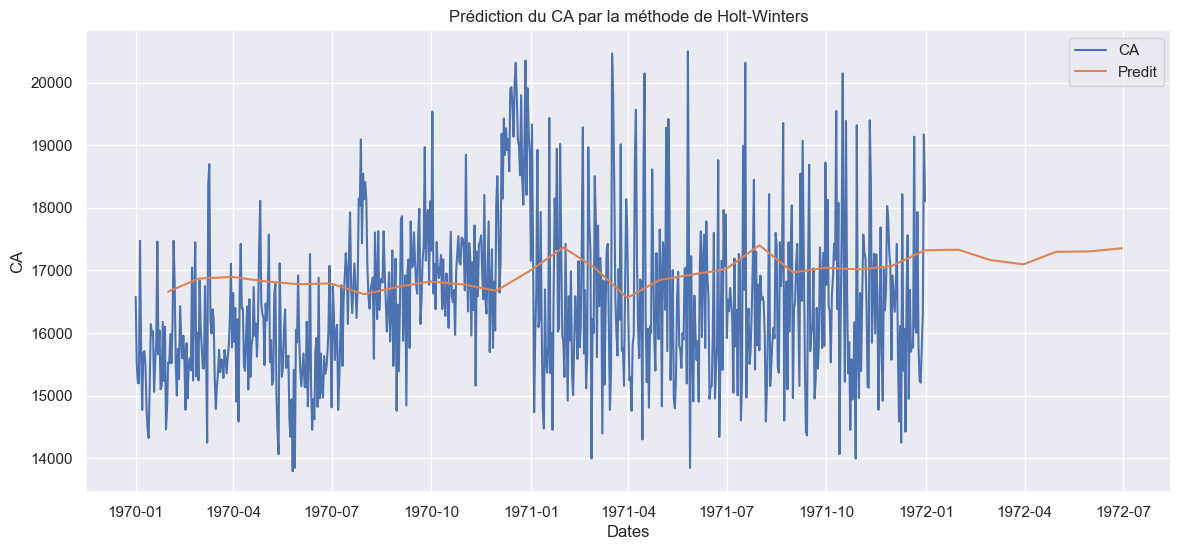

In [48]:

hw = ExponentialSmoothing(np.asarray(ca_journalier['CA']), seasonal_periods=30, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(30)

plt.figure(figsize=(14,6))
plt.plot(ca_journalier['CA'], label='CA')
plt.plot(pd.date_range(ca_journalier.index[len(ca_journalier)-1], periods=30, freq='M'), hw_pred, label='Predit')
plt.ylabel('CA')
plt.xlabel('Dates')
plt.title('Prédiction du CA par la méthode de Holt-Winters')
plt.legend()
plt.show()

### 3. Analyse de la clientèle

On choisi de supprimer les valeurs entre le 2 et le 27 octobre 2021 pour diminuer l'influence de l'absence de la catégorie 1

In [49]:
start_date = dt.datetime(2021,10,2)
end_date = dt.datetime(2021,10,27)
data = data.loc[(data['date'] < start_date) | (data['date'] > end_date)]


#### 3.1. RFM

La RFM est une méthode de ségmentation des clients en fonction de leurs habitudes d'achats.<br>
Le classement RFM se fait en fonction de 3 critères :
- Récence : date du dernier achat ou dernier contact client
- Fréquence : fréquence des achats sur une période de référence donnée
- Montant : somme des achats cumulés sur cette période
Un score est calculé pour chaque client. De ce score dépend sa catégorie.

In [50]:
panier_client =data.groupby(['client_id','sex','age']).agg(panier=('price' , np.sum),
                                                            nb_articles = ('session_id', len),                                                                                      
                                                            ).reset_index()
panier_client.describe()

,age,panier,nb_articles
count,8599.000000,8599.000000,8599.000000
mean,44.738109,1351.935409,77.110478
std,16.909376,5069.461752,303.300439
min,19.000000,8.300000,1.000000
25%,31.000000,538.130000,26.000000
50%,44.000000,1011.330000,50.000000
75%,57.000000,1749.215000,94.000000
max,94.000000,315144.360000,24667.000000


**Récence**

In [51]:
recency = data.groupby(by='client_id',as_index=False)['date'].max()
recency.columns = ['client_id', 'dernier_achat']
recent_date = recency['dernier_achat'].max()
recency['Recency'] = recency['dernier_achat'].apply(lambda x: (recent_date - x).days)
recency.head()


,client_id,dernier_achat,Recency
0,c_1,2023-01-15 20:46:25.222740,44
1,c_10,2023-01-27 03:39:36.431524,32
2,c_100,2022-09-20 05:26:43.133053,161
3,c_1000,2023-01-24 13:34:23.415697,35
4,c_1001,2023-02-23 23:19:47.625822,5


**Fréquence**

In [52]:
frequency = data.drop_duplicates().groupby(by=['client_id'], as_index=False)['session_id'].count()
frequency.columns = ['client_id', 'Frequency']
frequency.head()


,client_id,Frequency
0,c_1,38
1,c_10,58
2,c_100,8
3,c_1000,124
4,c_1001,99


**Monétaire**

In [53]:
monetary = panier_client[['client_id','panier']]
monetary.columns = ['client_id', 'Monetary']
monetary.head()

,client_id,Monetary
0,c_1,550.19
1,c_10,1353.60
2,c_100,254.85
3,c_1000,2251.90
4,c_1001,1767.27


**Merge**

In [54]:
rf_df = recency.merge(frequency, on='client_id')
rfm_df = rf_df.merge(monetary, on='client_id').drop(columns='dernier_achat')
rfm_df.head()

,client_id,Recency,Frequency,Monetary
0,c_1,44,38,550.19
1,c_10,32,58,1353.60
2,c_100,161,8,254.85
3,c_1000,35,124,2251.90
4,c_1001,5,99,1767.27


**Ranking**

In [55]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# Normalisation du rang par rapport au total
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()


,client_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,c_1,44,38,550.19,24.473354,38.050936,38.050936
1,c_10,32,58,1353.60,32.290983,56.250727,56.250727
2,c_100,161,8,254.85,4.630901,4.517967,4.517967
3,c_1000,35,124,2251.90,29.808438,83.631818,83.631818
4,c_1001,5,99,1767.27,78.898371,76.985696,76.985696


In [56]:
#Calcul du score RFM sur 5
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 *rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['client_id', 'RFM_Score']].head()


,client_id,RFM_Score
0,c_1,1.80
1,c_10,2.63
2,c_100,0.23
3,c_1000,3.78
4,c_1001,3.86


In [57]:
#Affectation des catégories
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >	4.5, "Top Customers",
									(np.where(rfm_df['RFM_Score'] > 4,"High value Customer",
										(np.where(rfm_df['RFM_Score'] > 3,"Medium Value Customer",
											np.where(rfm_df['RFM_Score'] > 1.6,'Low Value Customers', 'Lost Customers'))))))
rfm_df[['client_id', 'RFM_Score', 'Customer_segment']].head(5)


,client_id,RFM_Score,Customer_segment
0,c_1,1.80,Low Value Customers
1,c_10,2.63,Low Value Customers
2,c_100,0.23,Lost Customers
3,c_1000,3.78,Medium Value Customer
4,c_1001,3.86,Medium Value Customer


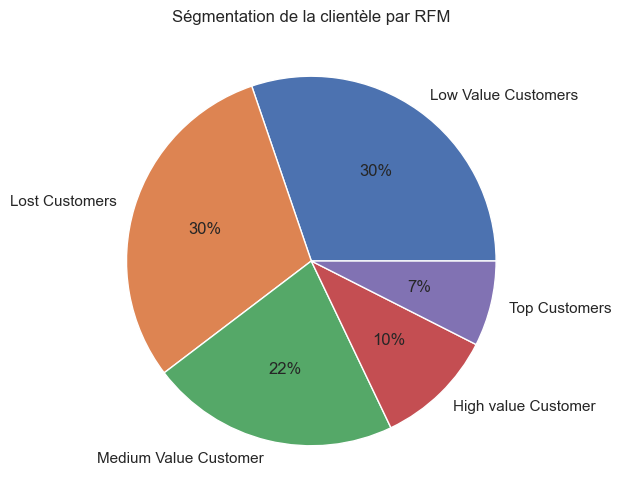

In [58]:
plt.pie(rfm_df.Customer_segment.value_counts(),
		labels=rfm_df.Customer_segment.value_counts().index,
		autopct='%.0f%%')
plt.title('Ségmentation de la clientèle par RFM')
plt.show()


*Par age et sex*

In [59]:
rfm_df=rfm_df.merge(customers,on='client_id').drop(columns='birth')
rfm_df.head()

,client_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,sex,age
0,c_1,44,38,550.19,24.47,38.05,38.05,1.80,Low Value Customers,m,68
1,c_10,32,58,1353.60,32.29,56.25,56.25,2.63,Low Value Customers,m,67
2,c_100,161,8,254.85,4.63,4.52,4.52,0.23,Lost Customers,m,31
3,c_1000,35,124,2251.90,29.81,83.63,83.63,3.78,Medium Value Customer,f,57
4,c_1001,5,99,1767.27,78.90,76.99,76.99,3.86,Medium Value Customer,m,41


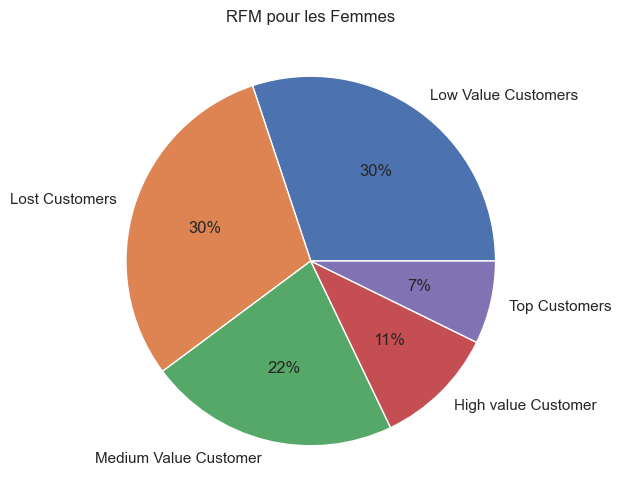

In [60]:
rfm_df_f = rfm_df[rfm_df['sex']=='f']
plt.pie(rfm_df_f.Customer_segment.value_counts(),
		labels=rfm_df.Customer_segment.value_counts().index,
		autopct='%.0f%%')
plt.title('RFM pour les Femmes')
plt.show()


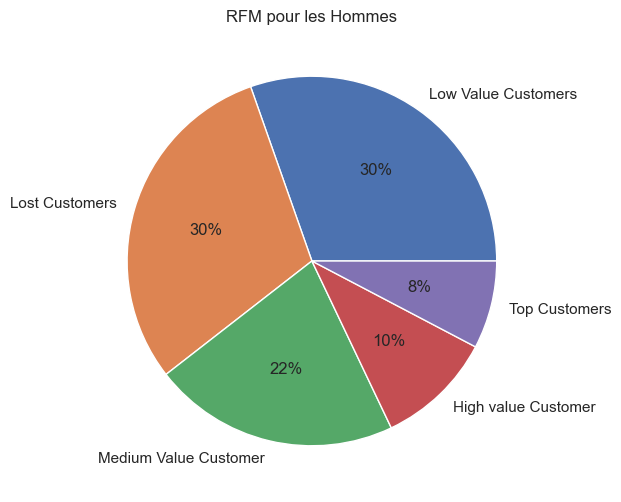

In [61]:
rfm_df_m = rfm_df[rfm_df['sex']=='m']
plt.pie(rfm_df_m.Customer_segment.value_counts(),
		labels=rfm_df.Customer_segment.value_counts().index,
		autopct='%.0f%%')
plt.title('RFM pour les Hommes')
plt.show()


In [62]:
rfm_df.groupby(['Customer_segment','sex'])['RFM_Score'].count()

Customer_segment       sex
High value Customer    f       476
                       m       422
Lost Customers         f      1348
                       m      1242
Low Value Customers    f      1347
                       m      1252
Medium Value Customer  f       982
                       m       888
Top Customers          f       325
                       m       317
Name: RFM_Score, dtype: int64

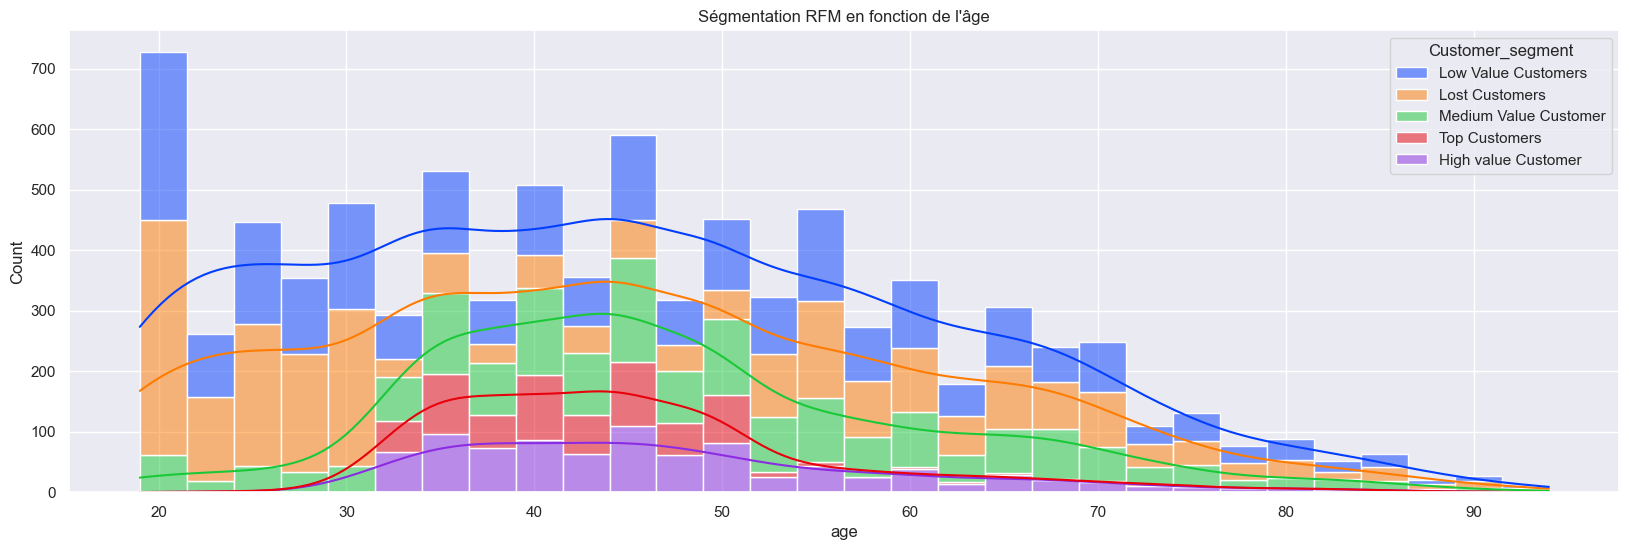

In [63]:
sns.histplot(data=rfm_df,stat="count", multiple="stack",
             x="age", kde=True,
             palette="bright", hue="Customer_segment",
             element="bars", legend=True)
plt.title("Ségmentation RFM en fonction de l'âge")

plt.show()

#### 3.2. Panier total par client

In [64]:
panier_client.describe()

,age,panier,nb_articles
count,8599.000000,8599.000000,8599.000000
mean,44.738109,1351.935409,77.110478
std,16.909376,5069.461752,303.300439
min,19.000000,8.300000,1.000000
25%,31.000000,538.130000,26.000000
50%,44.000000,1011.330000,50.000000
75%,57.000000,1749.215000,94.000000
max,94.000000,315144.360000,24667.000000


In [65]:
Compte_Zscore(panier_client,'sex','panier','m')

3


In [66]:
Compte_Zscore(panier_client,'sex','panier','f')

1


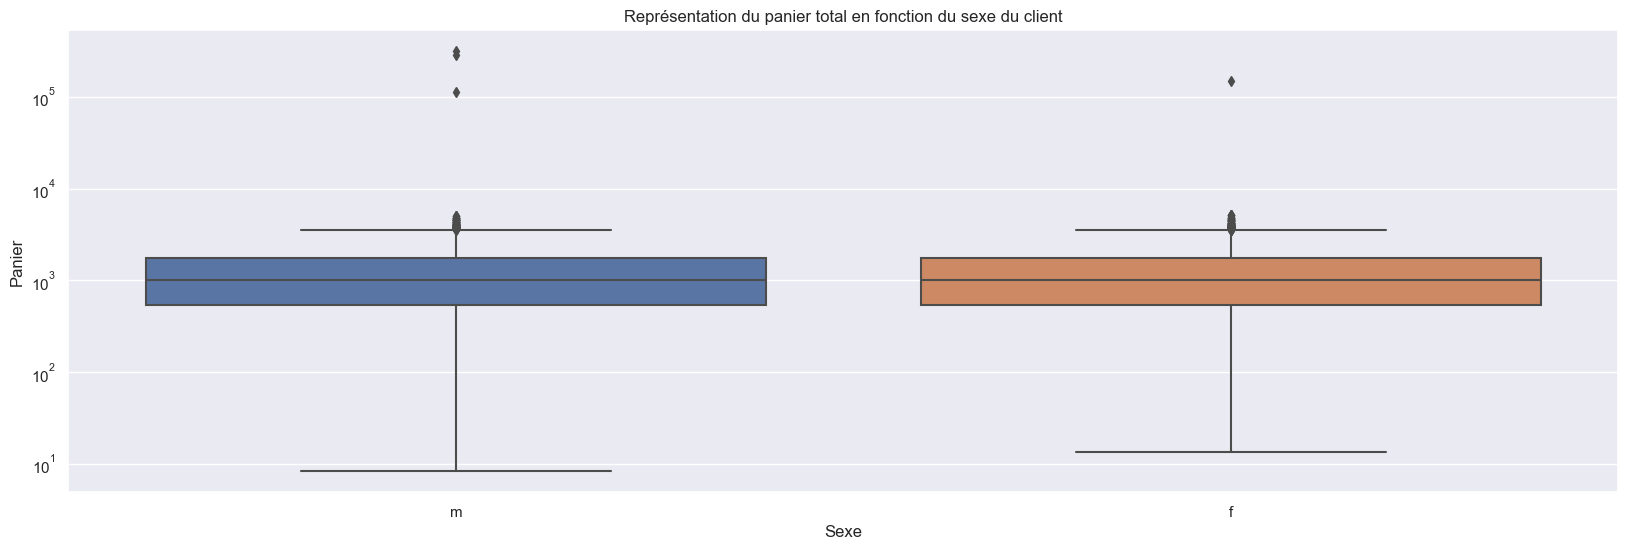

In [67]:
sns.boxplot(panier_client,x='sex',y='panier').set(yscale='log')
plt.ylabel('Panier')
plt.xlabel('Sexe')
plt.title('Représentation du panier total en fonction du sexe du client')
plt.show()

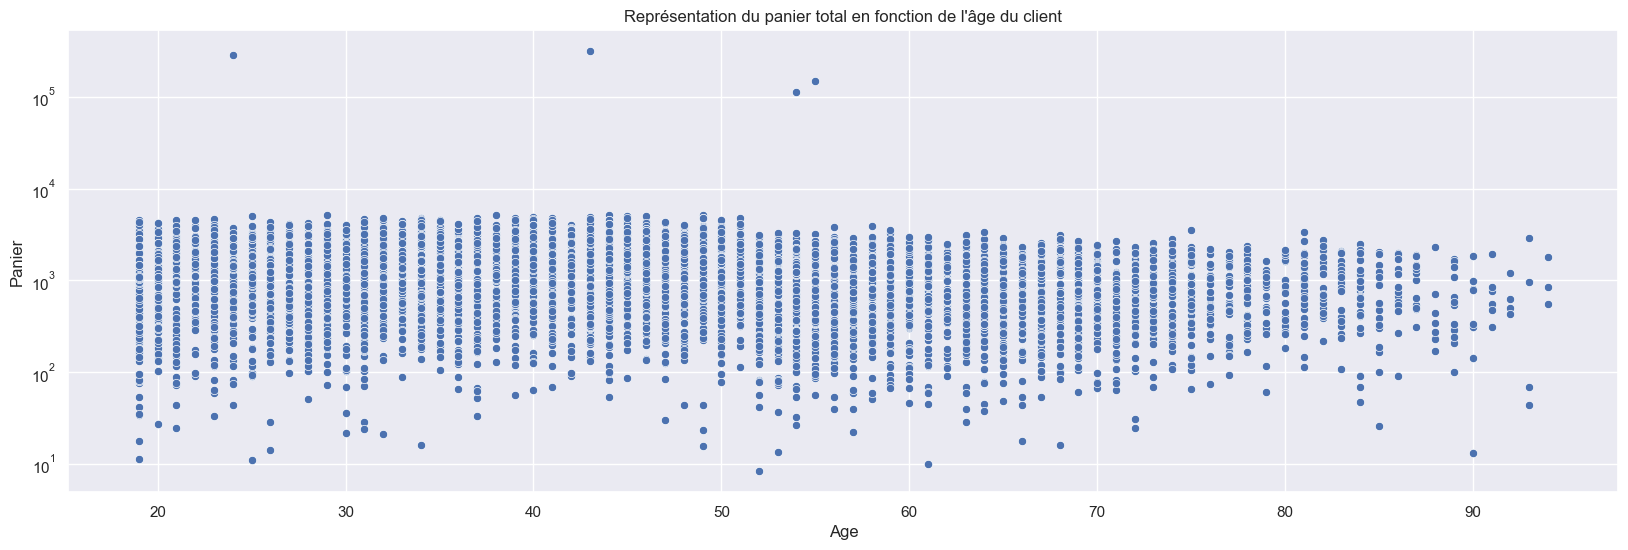

In [68]:
sns.scatterplot(panier_client,x='age',y='panier').set(yscale='log')
plt.ylabel('Panier')
plt.xlabel('Age')
plt.title("Représentation du panier total en fonction de l'âge du client")
plt.show()

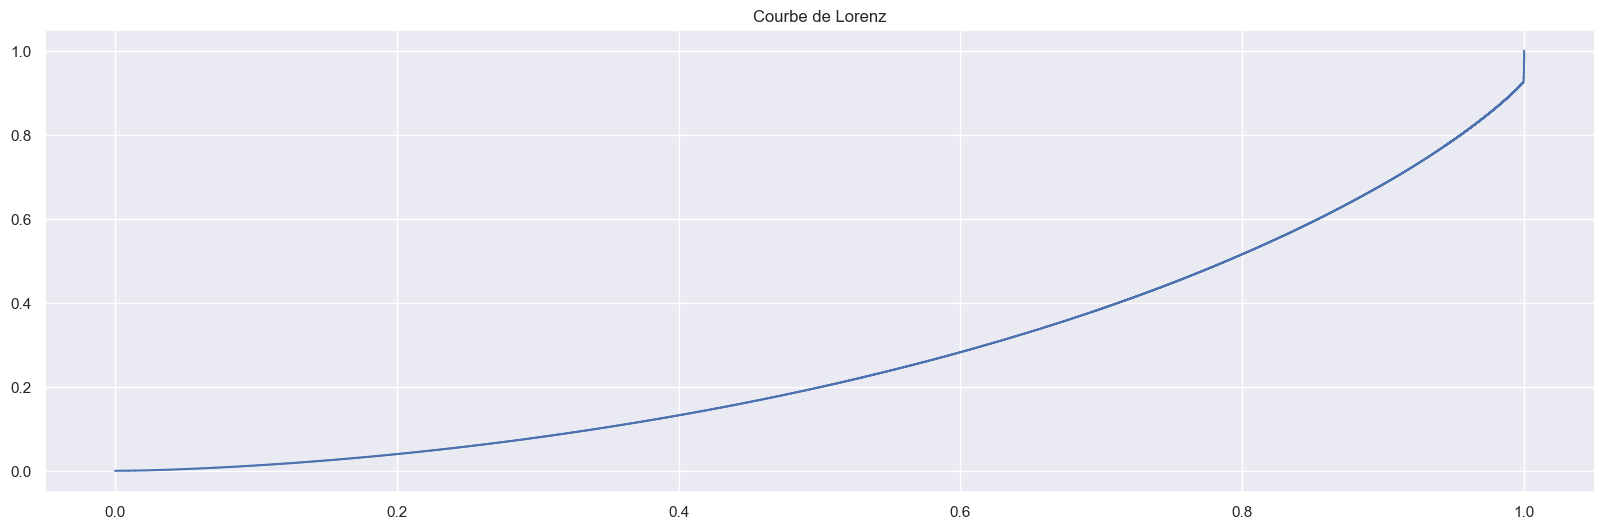

In [69]:
Courbe_Lorenz(panier_client,'panier')


20% des clients sont responsables de 50% du CA 

#### 3.3.Panier Moyen

In [70]:
panier_moyen =data.groupby(['client_id','session_id','sex','age']).agg(panier=('price' , np.sum),
                                            nb_articles = ('session_id', len),                                                                                      
                                            ).reset_index()
panier_moyen=panier_moyen.groupby (['client_id','sex','age']).agg(panier=('panier' , np.mean),
                                                                               articles_moyens=('nb_articles',np.mean)).reset_index()
print(panier_moyen)

     client_id sex   age      panier  articles_moyens
0          c_1   m  68.0   17.193438         1.187500
1         c_10   m  67.0   39.811765         1.705882
2        c_100   m  31.0   50.970000         1.600000
3       c_1000   f  57.0   24.477174         1.347826
4       c_1001   m  41.0   39.272667         2.200000
...        ...  ..   ...         ...              ...
8594     c_995   m  68.0   21.045556         1.555556
8595     c_996   f  53.0   20.661410         1.205128
8596     c_997   f  29.0   62.261739         2.521739
8597     c_998   m  22.0  120.864348         2.304348
8598     c_999   m  59.0   16.912683         1.097561

[8599 rows x 5 columns]


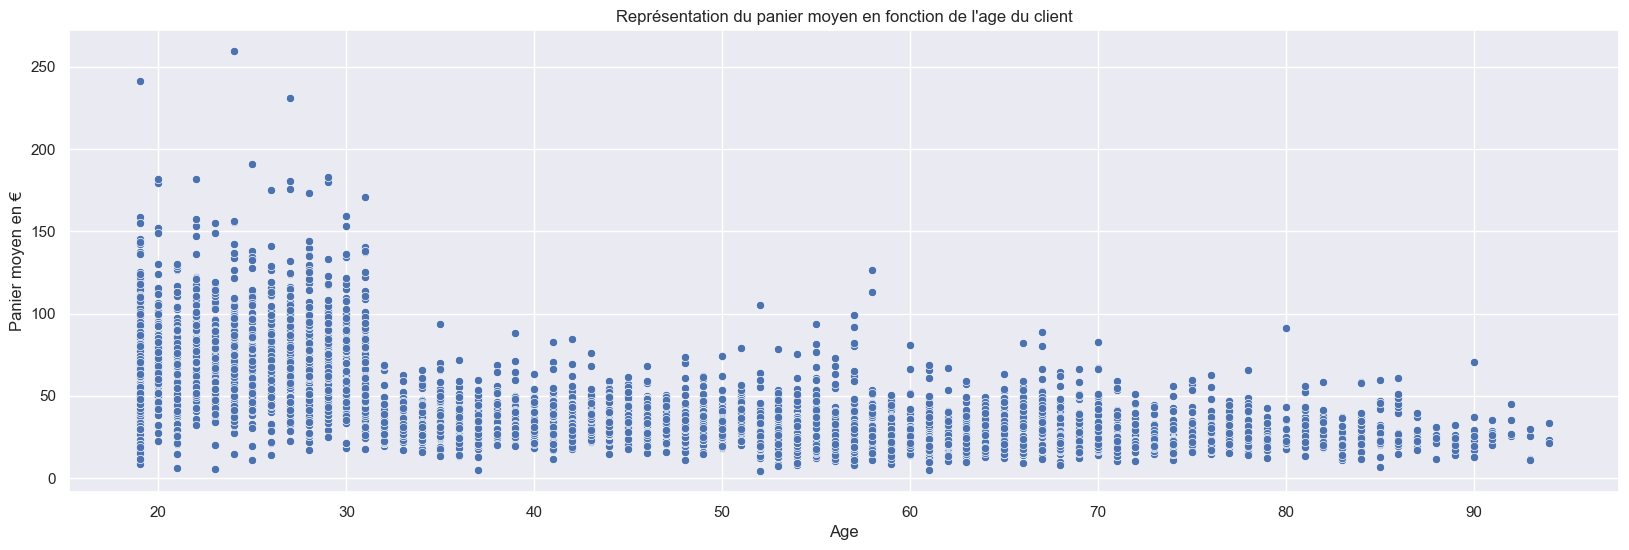

In [71]:
sns.scatterplot(panier_moyen,x='age',y='panier')
plt.ylabel('Panier moyen en €')
plt.xlabel('Age')
plt.title("Représentation du panier moyen en fonction de l'age du client")
plt.show()

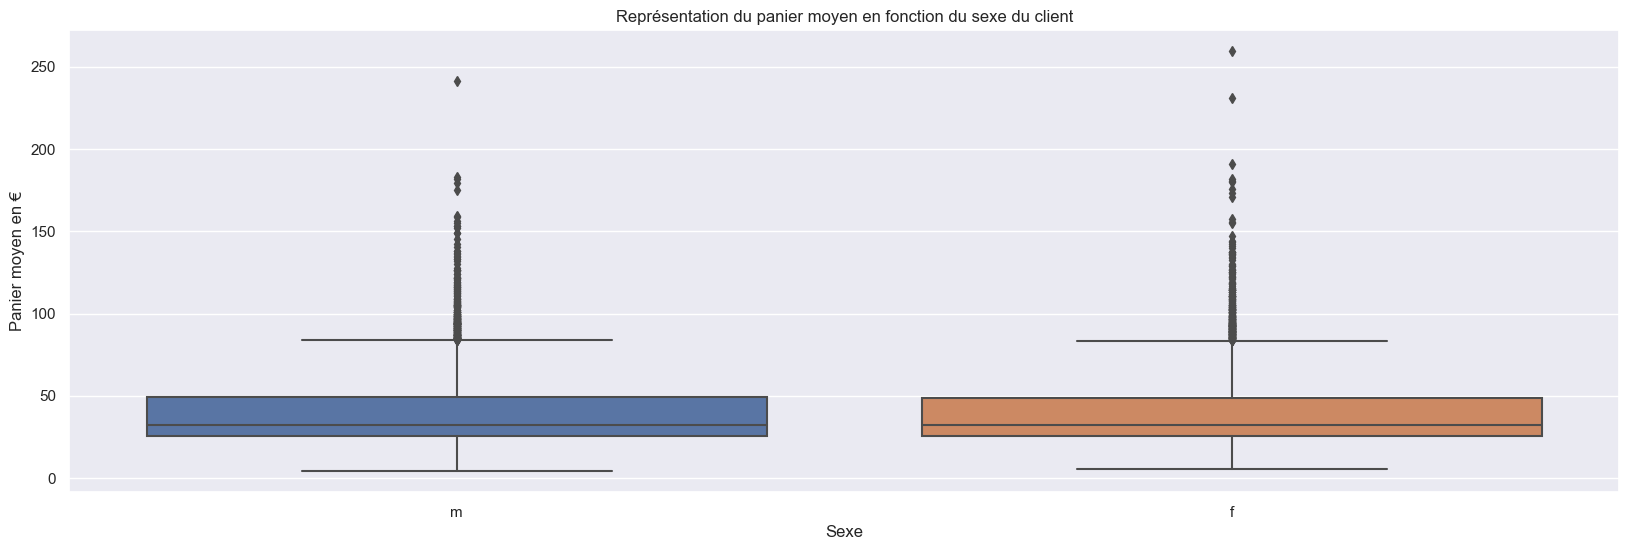

In [72]:
sns.boxplot(panier_moyen,x='sex',y='panier')
plt.ylabel('Panier moyen en €')
plt.xlabel('Sexe')
plt.title('Représentation du panier moyen en fonction du sexe du client')
plt.show()

#### 3.4. Fréquences d'achat

In [73]:
frequence_achat =data.groupby(['client_id','sex','age']).agg(panier=('price' , np.sum),
                                                            nombre_session = ('session_id', lambda x: x.nunique()),                                                                                      
                                                            ).reset_index().sort_values(by='nombre_session')

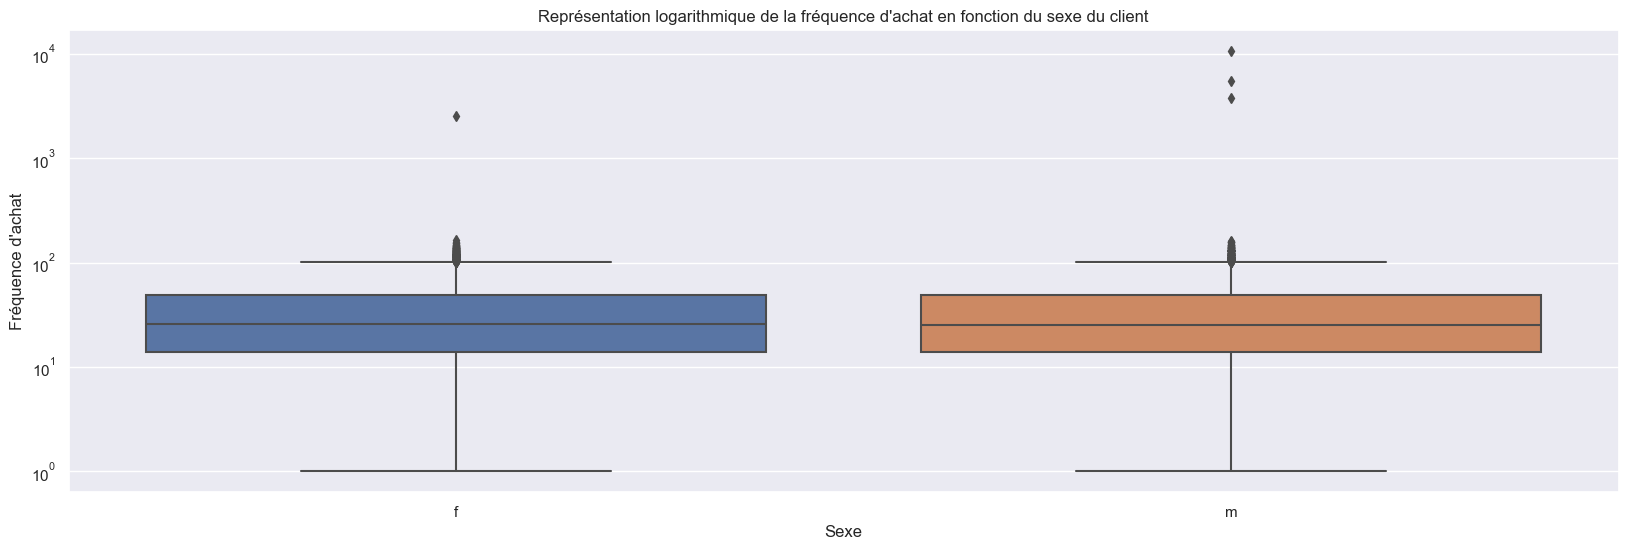

In [74]:

sns.boxplot(frequence_achat,x='sex',y='nombre_session').set(yscale='log')
plt.ylabel("Fréquence d'achat")
plt.xlabel('Sexe')
plt.title("Représentation logarithmique de la fréquence d'achat en fonction du sexe du client")
plt.show()

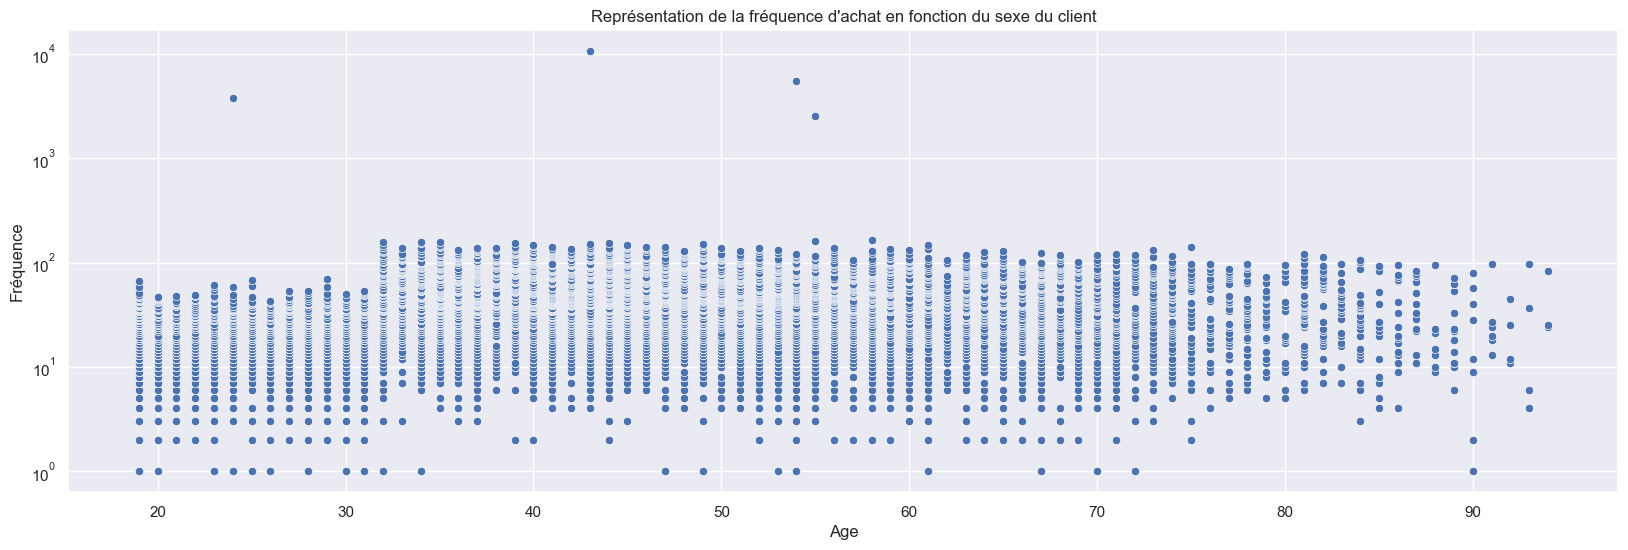

In [75]:

sns.scatterplot(frequence_achat,x='age',y='nombre_session').set(yscale='log')
plt.ylabel('Fréquence')
plt.xlabel('Age')
plt.title("Représentation de la fréquence d'achat en fonction du sexe du client")
plt.show()

### 4. Analyses statistiques

Création de différentes tables utilisées pour les analyses

In [76]:
#lien entre sex, categorie et nb d'articles
age_categ = data.groupby(['categ','age','sex'],as_index=False)['client_id'].value_counts().sort_values(by='count')


#lien sexe et catégorie
sex_cat = data.groupby(['sex','categ'],as_index=False)['session_id'].value_counts()


##### 4.1 Analyses de deux variables qualitatives

**Corrélation entre le sexe et la catégorie d'achat - Test du Khi2**

H0 : La categorie d'achat est indépendante du sexe du client <br>
H1 : Il y a un lien entre le sexe de client et la catéogrie d'achat

In [77]:
table_contingence=pd.crosstab(sex_cat["sex"],sex_cat["categ"])
print('Table de contigence :-\n',table_contingence)

Table de contigence :-
 categ     0.0    1.0    2.0
sex                        
f      108181  89702  14166
m      109178  89514  15592


In [78]:
c, p, dof, expected = st.chi2_contingency(table_contingence, correction = True) 
# Print the p-value
print(dof)
print(expected)
reponse_test(p)

2
[[108109.76065892  89138.24072732  14800.99861376]
 [109249.23934108  90077.75927268  14957.00138624]]
P-value =  4.672345579732661e-14
Rejet de H0


Il y a donc un lien entre le sexe du client et la catégorie d'achat.

##### 4.2 Analyses de deux variables quantitatives

**Lien entre l'age et le panier global**

H0 : Distribution Normale <br>
H0 : Distribution qui ne suit pas la loi normale <br>

In [79]:
stat, p = st.normaltest(panier_client['age'])
reponse_test(p)
print('------------------------------------')
stat, p = st.normaltest(panier_client['panier'])
reponse_test(p)

P-value =  3.498339112568693e-110
Rejet de H0
------------------------------------
P-value =  0.0
Rejet de H0


Les distributions ne suivant pas la loi normale, nous utilisons le test de Spearman. <br>
H0 : Il n'y a pas de corrélation significative entre l'age de client et le panier moyen <br>
H1 : Il y a corrélation entre l'âge de client et le panier moyen

In [80]:
stat, p = st.spearmanr(panier_client['age'],panier_client['panier'])
print(f"Corr : {stat}")
reponse_test(p)

Corr : -0.17924420955842596
P-value =  5.214555785355808e-63
Rejet de H0


Il y a corrélation entre l'age et le panier moyen.

**Lien entre l'age et la fréquence d'achat**

In [81]:
stat, p = st.normaltest(frequence_achat['age'])
reponse_test(p)
print('------------------------------------')
stat, p = st.normaltest(frequence_achat['nombre_session'])
reponse_test(p)

P-value =  3.498339112568693e-110
Rejet de H0
------------------------------------
P-value =  0.0
Rejet de H0


Les distributions ne suivant pas la loi normale, nous utilisons le test de Spearman.<br>
H0 : Il n'y a pas de corrélation significative entre l'age du client et la fréquence d'achat <br>
H1 : Il y a corrélation entre l'age du client et la fréquence d'achat

In [82]:
stat, p = st.spearmanr(frequence_achat['age'],frequence_achat['nombre_session'])
print(f"Corr : {stat}")
reponse_test(p)

Corr : 0.21362254873410183
P-value =  2.5565077643959493e-89
Rejet de H0


Il y  a corrélation. 

**Lien entre l'age et le panier moyen**

In [83]:
stat, p = st.normaltest(panier_moyen['age'])
reponse_test(p)
print('------------------------------------')
stat, p = st.normaltest(panier_moyen['panier'])
reponse_test(p)

P-value =  3.498339112568693e-110
Rejet de H0
------------------------------------
P-value =  0.0
Rejet de H0


H0 : Il n'y a pas corrélation entre l'age du client et le panier moyen <br>
H1 : Il existe une corrélation entre l'age du client et le panier moyen

In [84]:
stat, p = st.spearmanr(panier_moyen['age'],panier_moyen['panier'])
print(f"Corr : {stat}")
reponse_test(p)

Corr : -0.6972454471397027
P-value =  0.0
Rejet de H0


Il y a corrélation.

##### 4.3 Analyses d'une variable qualitative et d'une variable quantitative

**Lien entre le sexe et le panier moyen**

In [85]:
df_anova = panier_moyen[['sex','panier']]
grps = pd.unique(df_anova.sex.values)
print(grps)
d_data = {grp:df_anova['panier'][df_anova.sex == grp] for grp in grps}
print(d_data) 

['m' 'f']
{'m': 0        17.193438
1        39.811765
2        50.970000
4        39.272667
6        27.792683
           ...    
8590     27.928462
8592     36.933333
8594     21.045556
8597    120.864348
8598     16.912683
Name: panier, Length: 4121, dtype: float64, 'f': 3       24.477174
5       19.187647
8       37.635455
10      22.366842
12      57.091111
          ...    
8586    20.270127
8591    27.458182
8593    69.162143
8595    20.661410
8596    62.261739
Name: panier, Length: 4478, dtype: float64}


Test de normalité

H0 : Distribution normale <br>
H1 : Distribution différente

In [86]:
stat, p = st.shapiro(d_data['m'])
reponse_test(p)
print('------------------------------------')
stat, p = st.shapiro(d_data['f'])
reponse_test(p)



P-value =  0.0
Rejet de H0
------------------------------------
P-value =  0.0
Rejet de H0


Test d'égalité des variances

H0 : Egalité des variances <br>
H1 : Variances différentes

In [87]:
stat, p = st.levene(d_data['m'], d_data['f'])
reponse_test(p)

P-value =  0.7482292249241425
Acceptation de H0


Anova

H0 : Les 2 groupes ont la même moyenne <br>
H1 : Les 2 groupes n'ont pas la même moyenne

In [88]:
stats, p = st.kruskal(d_data['m'], d_data['f'])
reponse_test(p)

P-value =  0.27107343202348405
Acceptation de H0


Le panier moyen est de même moyenne pour les hommes et pour les femmes. Il n'est donc pas corrélé au sexe.

**Lien entre le sexe et la fréquence d'achat**

In [89]:
df_anova1 = frequence_achat[['sex','nombre_session']]
grps = pd.unique(df_anova1.sex.values)
print(grps)
d_data = {grp:df_anova1['nombre_session'][df_anova1.sex == grp] for grp in grps}
print(d_data) 

['f' 'm']
{'f': 2793       1
5589       1
1434       1
5467       1
3247       1
        ... 
634      153
1197     154
708      158
8343     164
6337    2538
Name: nombre_session, Length: 4478, dtype: int64, 'm': 5690        1
2584        1
4044        1
5828        1
694         1
        ...  
5103      158
1406      161
4388     3790
2724     5484
677     10620
Name: nombre_session, Length: 4121, dtype: int64}


H0 : Les 2 groupes ont la même moyenne <br>
H1 : Les 2 groupes n'ont pas la même moyenne

In [90]:
F, p = st.f_oneway(d_data['m'], d_data['f'])
reponse_test(p)

P-value =  0.19219714230756807
Acceptation de H0


La fréquence d'achat est de même moyenne pour les hommes et pour les femmes. Elle n'est donc pas corrélé au sexe.

**Lien entre le sexe et le panier global**

In [91]:
df_anova2 = panier_client[['sex','panier']]
grps = pd.unique(df_anova2.sex.values)
print(grps)
d_data = {grp:df_anova2['panier'][df_anova2.sex == grp] for grp in grps}
print(d_data) 

['m' 'f']
{'m': 0        550.19
1       1353.60
2        254.85
4       1767.27
6       1139.50
         ...   
8590     726.14
8592     443.20
8594     189.41
8597    2779.88
8598     693.42
Name: panier, Length: 4121, dtype: float64, 'f': 3       2251.90
5        326.19
8        827.98
10       424.97
12       513.82
         ...   
8586    1601.34
8591     302.04
8593     968.27
8595    1611.59
8596    1432.02
Name: panier, Length: 4478, dtype: float64}


H0 : Les 2 groupes ont la même moyenne <br>
H1 : Les 2 groupes n'ont pas la même moyenne

In [92]:
F, p = st.f_oneway(d_data['m'], d_data['f'])
reponse_test(p)

P-value =  0.19618343627122545
Acceptation de H0


Le panier global est de même moyenne pour les hommes et pour les femmes. Il n'est donc pas corrélé au sexe.

**Lien entre l'age et la catégorie d'achat**

In [93]:
df_anova3 = age_categ[['age','categ']]
grps = pd.unique(df_anova3.categ.values)
print(grps)
d_data = {grp:df_anova3['age'][df_anova3.categ == grp] for grp in grps}
print(d_data) 

[2. 0. 1.]
{2.0: 19829    94.0
18616    36.0
18615    36.0
18614    36.0
19348    56.0
         ... 
17179    23.0
16513    19.0
18000    29.0
19279    55.0
17309    24.0
Name: age, Length: 3536, dtype: float64, 0.0: 888     25.0
887     25.0
886     25.0
840     25.0
841     25.0
        ... 
2583    38.0
2479    37.0
5319    54.0
5378    55.0
3477    43.0
Name: age, Length: 7841, dtype: float64, 1.0: 8465     21.0
14139    56.0
14198    57.0
10017    31.0
9642     29.0
         ... 
14266    58.0
8864     24.0
13815    55.0
13755    54.0
11928    43.0
Name: age, Length: 8453, dtype: float64}


In [94]:
print("Normalité")
stat, p = st.shapiro(d_data[0])
reponse_test(p)
print('------------------------------------')
stat, p = st.shapiro(d_data[1])
reponse_test(p)
print('------------------------------------')
stat, p = st.shapiro(d_data[2])
reponse_test(p)
print('------------------------------------')
print("Egalité des variances")
stat, p = st.levene(d_data[0], d_data[1], d_data[2])
reponse_test(p)


Normalité
P-value =  1.2982776745015525e-31
Rejet de H0
------------------------------------
P-value =  2.7053933383345074e-38
Rejet de H0
------------------------------------
P-value =  0.0
Rejet de H0
------------------------------------
Egalité des variances
P-value =  1.7255517378263257e-21
Rejet de H0


In [95]:
F, p = st.f_oneway(d_data[0], d_data[1],d_data[2])
reponse_test(p)

P-value =  7.443603352765214e-254
Rejet de H0


Pas d'égalité des médianes, donc l'âge et la catégorie d'achat sont corrélés.